# Predicting an English Premier League Match Using EA Sports FIFA Rankings
### Nick Riley
### CMSC 320
## Introduction
The English Premier League (EPL) is the top tier league for European Football (Soccer) in England. It has 20 teams, and in a singular season from August to May, the teams play each other team once, one time at home, another away, tallying up to 38 matches per season per team. Most US sports have divisions and seperating leagues, where it all culminates to a playoff and an eventual championship match or series. Also, their records determine their standing as with most of these leagues there are no draws. This is different for the EPL and leagues alike as there are no divisions or playoffs/championships. A win is 3 points, a draw is 1 point, and a loss is 0 points. Each team plays their 38 matches, and after those, whoever has the most points wins. Besides number 1 being crowned champion, 20, 19, and 18 all get sent down into the second division for the next season, and 3 teams (one being the champion and the others going through a playoff) get promoted from the second division into the EPL. 

EA Sports FIFA, or just FIFA, is an annually released Sports Simulation video game released by Electronic Arts. Its first release came in the 1990s and has been releasing yearly since. It is the most popular and widely regarded as the most accurate soccer/footbal simulation game you can have. Besides the gameplay, one of the reasonings that FIFA has survived for so long is its exclusive rights from partnership with so many clubs and players around the world that you can play with. Its dominance has begun to wane as partnerships have fallen through, but it still has exclusive ownership of the most popular league and its players, the EPL. Every year, when the new FIFA is beginning to be announced, a large marketing tool is FIFA's rating system. Each player has nearly 30 numerical stats that influence their overall rating, each from 1 to 99. Then, a clubs overall rating comes from combining all of its players' ratings. While these ratings always come with discrepencies and controversy, from the surface, they do a decent job at predicting a teams rating in reference to other teams.

In this project, we will analyze their use in predicting premier league matches.

First we will gather our libraries.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

Now, we will populate a data frame with the match history of the premier league since 2006. We used a dataset from Football-Data. You can find it [here](https://www.football-data.co.uk/englandm.php). We will populate each season into this dataframe. Although they do not all record the same data, they have the full time result, date, the amount of goals, and the teams playing, which is all we will really need.

In [2]:
data = pd.read_csv('data/E0.csv')
data['Season'] = "21/22"
for i in range(1,16):
    d = pd.read_csv('data/E0 ('+str(i)+').csv')
    d['Season'] = ''+str(21-i)+'/'+str(22-i)
    data=data.append(d)

We will clean our data by dropping any nulled dates.

In [3]:
data = data[data['Date'].notna()]

Next we will begin looking at our FIFA ratings data. Unfortunately, I found no already created datasets, so I will create one using some webscraping from [fifaindex.com](https://www.fifaindex.com/) and we will use its team data over the years. This has everything we need with minimal problems. The only problem occur with two specific teams. 11/12 Arsenal and 12/13 Southampton are listed under the incorrect leagues, we will account for this later.

In [4]:
fifa07 = requests.get("https://www.fifaindex.com/teams/fifa07_3/?league=13&order=desc")
fifa08 = requests.get("https://www.fifaindex.com/teams/fifa08_4/?league=13&order=desc")
fifa09 = requests.get("https://www.fifaindex.com/teams/fifa09_5/?league=13&order=desc")
fifa10 = requests.get("https://www.fifaindex.com/teams/fifa10_6/?league=13&order=desc")
fifa11 = requests.get("https://www.fifaindex.com/teams/fifa11_7/?league=13&order=desc")
fifa12 = requests.get("https://www.fifaindex.com/teams/fifa12_9/?league=13&order=desc")
fifa13 = requests.get("https://www.fifaindex.com/teams/fifa13_10/?league=13&order=desc")
fifa14 = requests.get("https://www.fifaindex.com/teams/fifa14_13/?league=13&order=desc")
fifa15 = requests.get("https://www.fifaindex.com/teams/fifa15_14/?league=13&order=desc")
fifa16 = requests.get("https://www.fifaindex.com/teams/fifa16_73/?league=13&order=desc")
fifa17 = requests.get("https://www.fifaindex.com/teams/fifa17_173/?league=13&order=desc")
fifa18 = requests.get("https://www.fifaindex.com/teams/fifa18_278/?league=13&order=desc")
fifa19 = requests.get("https://www.fifaindex.com/teams/fifa19_353/?league=13&order=desc")
fifa20 = requests.get("https://www.fifaindex.com/teams/fifa20_419/?league=13&order=desc")
fifa21 = requests.get("https://www.fifaindex.com/teams/fifa21_486/?league=13&order=desc")
fifa22 = requests.get("https://www.fifaindex.com/teams/?league=13&order=desc")

From these different years ratings, we will parse with HTML and look for team names, overalls, defensive overalls, and attacking overalls. We will do this with regular expressions.

Below you will also notice a lot of if statements. This is for compatability between our two datasets. On FIFA Index, many teams have different spellings, and we want everything to be uniform so all of the teams in the previous dataset actually have a rating from its respective year.

In [5]:
fifas = [fifa07,fifa08,fifa09,fifa10,fifa11,fifa12,fifa13,fifa14,\
         fifa15,fifa16,fifa17,fifa18,fifa19,fifa20,fifa21,fifa22]
lst = dict()
j = 7
for fifa in fifas:
    root = BeautifulSoup(fifa.content)
    tables = root.find("table")
    overalls = tables.findAll("td", {"data-title":"OVR"})
    attacks = tables.findAll("td", {"data-title":"ATT"})
    defends = tables.findAll("td", {"data-title":"DEF"})
    
    teams = tables.findAll("a", text=re.compile("^(((([A-Z][a-z]+)|(&)|(AFC)|(F\.?C\.?)) ?)+)$"))
    teams = list(map(lambda x: re.search('>(((([A-Z][a-z]+)|(&amp;)|(AFC)|(F\.?C\.?)) ?)+)<',str(x))[1],teams))
    teams = [x for x in teams if 'Premier League' not in x]
    for i,team in enumerate(teams):
        if team == 'Manchester United':
            teams[i] = 'Man United'
        elif team == 'Manchester City':
            teams[i] = 'Man City'
        elif team == 'Wolverhampton Wanderers':
            teams[i] = 'Wolves'
        elif team == 'West Bromwich Albion' or team == 'West Bromwich':
            teams[i] = 'West Brom'
        elif team == 'Queens Park Rangers':
            teams[i] = 'QPR'
        elif team == 'Tottenham Hotspur':
            teams[i] = 'Tottenham'
        elif team == 'Cardiff City':
            teams[i] = 'Cardiff'
        elif team == 'Hull City':
            teams[i] = 'Hull'
        elif team == 'Newcastle United':
            teams[i] = 'Newcastle'
        elif team == 'Leicester City':
            teams[i] = 'Leicester'
        elif team == 'West Ham United':
            teams[i] = 'West Ham'
        elif team == 'Charlton Athletic':
            teams[i] = 'Charlton'
        elif team == 'Blackburn Rovers':
            teams[i] = 'Blackburn'
        elif team == 'Birmingham City':
            teams[i] = 'Birmingham'
        elif team == 'Huddersfield Town':
            teams[i] = 'Huddersfield'
        elif team == 'Swansea City':
            teams[i] = 'Swansea'
        elif team == 'Stoke City':
            teams[i] = 'Stoke'
        elif team == 'Norwich City':
            teams[i] = 'Norwich'
        elif team == 'Leeds United':
            teams[i] = 'Leeds'
        elif team == 'Brighton &amp; Hove Albion':
            teams[i] = 'Brighton'
        elif team == 'AFC Bournemouth':
            teams[i] = 'Bournemouth'
        elif team == 'Wigan Athletic':
            teams[i] = 'Wigan'
        elif team == 'Arsenal FC' or team == 'Arsenal F.C.':
            teams[i] = 'Arsenal'
        elif team == 'Bolton Wanderers':
            teams[i] = 'Bolton'
        elif team == 'Chelsea FC' or team == 'Chelsea F.C.':
            teams[i] = 'Chelsea'
        elif team == 'Reading FC' or team == 'Reading F.C.':
            teams[i] = 'Reading'
        elif team == 'Derby County':
            teams[i] = 'Derby'
        
            
            
        
    overalls = list(map(lambda x: re.search('>(\d\d)<',str(x))[1],overalls))
    attacks = list(map(lambda x: re.search('>(\d\d)<',str(x))[1],attacks))
    defends = list(map(lambda x: re.search('>(\d\d)<',str(x))[1],defends))
    
    t = dict()
    for i,team in enumerate(teams):
        # This was one of the most glaringly incorrect values I found.
        # It says it was 69, but that just is nowhere near correct, it was 79
        if j == 16 and team == "Man United":
            attacks[i] = 79
        t[team] = overalls[i],attacks[i],defends[i]
    lst[str(j-1)+'/'+str(j)] = t
    j += 1

{k: lst[k] for k in list(lst)[:2]}

{'6/7': {'Chelsea': ('84', '86', '83'),
  'Man United': ('82', '88', '82'),
  'Arsenal': ('82', '84', '81'),
  'Liverpool': ('81', '82', '81'),
  'Newcastle': ('79', '83', '74'),
  'Tottenham': ('79', '83', '80'),
  'Everton': ('77', '80', '76'),
  'Blackburn': ('77', '79', '76'),
  'Man City': ('77', '79', '75'),
  'Middlesbrough': ('76', '81', '74'),
  'West Ham': ('76', '80', '76'),
  'Bolton': ('76', '79', '75'),
  'Charlton': ('75', '80', '75'),
  'Aston Villa': ('75', '79', '73'),
  'Fulham': ('75', '78', '76'),
  'Portsmouth': ('75', '76', '75'),
  'Wigan': ('74', '76', '73'),
  'Sheffield United': ('72', '79', '71'),
  'Reading': ('71', '73', '66'),
  'Watford': ('68', '71', '69')},
 '7/8': {'Man United': ('83', '89', '83'),
  'Chelsea': ('83', '87', '83'),
  'Liverpool': ('81', '85', '82'),
  'Arsenal': ('80', '84', '81'),
  'Tottenham': ('78', '84', '79'),
  'Newcastle': ('77', '82', '76'),
  'Blackburn': ('76', '82', '76'),
  'Everton': ('76', '79', '79'),
  'Portsmouth': ('

Next, we will clean up the dataset by removing all of the columns we will not be using. Then we will add in the data.

As mentioned before, the 11/12 Arsenal and 12/13 Southampton teams are not found in the correct place on the website and had to be hard coded in.

In [6]:
data.reset_index(inplace=True)

In [7]:
df = data.loc[:, data.columns.intersection(['Date','Season','HomeTeam', 'AwayTeam','FTR','FTHG','FTAG'])]#,'HTR','HTHG','HTAG'])]
df = df.astype({'FTHG':'int','FTAG':'int'})
df['HomeOVR'] = 0
df['HomeATT'] = 0
df['HomeDEF'] = 0

df['AwayOVR'] = 0
df['AwayATT'] = 0
df['AwayDEF'] = 0

for i,row in df.iterrows():
    
    # 2 teams have issues on the fifaindex website
    # 11/12 Arsenal when they are in the Pro League: 81 OVR, 84 ATT, 81 DEF 
    # 12/13 South Hampton when they are in the "npower Champ." league: 73 OVR, 71 ATT, 68 DEF
    # we will just manualy grab them
    season = row['Season']
    home = row['HomeTeam']
    away = row['AwayTeam']
    try:
        df.at[i,'HomeOVR'] = lst[season][home][0]
        df.at[i,'HomeATT'] = lst[season][home][1]
        df.at[i,'HomeDEF'] = lst[season][home][2]
        try:
            df.at[i,'AwayOVR'] = lst[season][away][0]
            df.at[i,'AwayATT'] = lst[season][away][1]
            df.at[i,'AwayDEF'] = lst[season][away][2]
        except:
            if away == 'Arsenal':
                df.at[i,'AwayOVR'] = 81
                df.at[i,'AwayDEF'] = 81
                df.at[i,'AwayATT'] = 84
                
                df.at[i,'HomeOVR'] = lst[season][home][0]
                df.at[i,'HomeATT'] = lst[season][home][1]
                df.at[i,'HomeDEF'] = lst[season][home][2]
                
            if away == 'Southampton':
                df.at[i,'AwayOVR'] = 73
                df.at[i,'AwayATT'] = 71
                df.at[i,'AwayDEF'] = 68
                
                df.at[i,'HomeOVR'] = lst[season][home][0]
                df.at[i,'HomeATT'] = lst[season][home][1]
                df.at[i,'HomeDEF'] = lst[season][home][2]
    except:
        if home == 'Arsenal':
                df.at[i,'HomeOVR'] = 81
                df.at[i,'HomeDEF'] = 81
                df.at[i,'HomeATT'] = 84
                
                df.at[i,'AwayOVR'] = lst[season][away][0]
                df.at[i,'AwayATT'] = lst[season][away][1]
                df.at[i,'AwayDEF'] = lst[season][away][2]
                
        if home == 'Southampton':
            df.at[i,'HomeOVR'] = 73
            df.at[i,'HomeATT'] = 71
            df.at[i,'HomeDEF'] = 68
            
            df.at[i,'AwayOVR'] = lst[season][away][0]
            df.at[i,'AwayATT'] = lst[season][away][1]
            df.at[i,'AwayDEF'] = lst[season][away][2]
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HomeOVR,HomeATT,HomeDEF,AwayOVR,AwayATT,AwayDEF
0,13/08/2021,Brentford,Arsenal,2,0,H,21/22,74,74,74,80,77,77
1,14/08/2021,Man United,Leeds,5,1,H,21/22,83,82,81,76,77,75
2,14/08/2021,Burnley,Brighton,1,2,A,21/22,76,77,76,76,75,77
3,14/08/2021,Chelsea,Crystal Palace,3,0,H,21/22,84,84,83,76,77,75
4,14/08/2021,Everton,Southampton,3,1,H,21/22,78,78,77,76,75,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,13/05/07,Middlesbrough,Fulham,3,1,H,6/7,76,81,74,75,78,76
6027,13/05/07,Portsmouth,Arsenal,0,0,D,6/7,75,76,75,82,84,81
6028,13/05/07,Sheffield United,Wigan,1,2,A,6/7,72,79,71,74,76,73
6029,13/05/07,Tottenham,Man City,2,1,H,6/7,79,83,80,77,79,75


Now that we have the main data that we need into a dataframe and each team has its respective FIFA ratings, we can begin exploring our data. First, we will look at the difference in rating for each result. We will define the difference as the winner's rating minus the loser's rating. If the match is a draw, the difference will be HomeOVR minus AwayOVR. We choose to do this as the home team should typically win more. This is reinforced by the first of the two graphs below.

In [8]:
df['DiffFT'] = 0
for i,row in df.iterrows():
    if row['FTR'] == 'H':
        df.at[i,'DiffFT'] = row['HomeOVR'] - row['AwayOVR']
    elif row['FTR'] == 'A':
        df.at[i,'DiffFT'] = row['AwayOVR'] - row['HomeOVR']
    else:
        df.at[i,'DiffFT'] = (row['HomeOVR'] - row['AwayOVR'])
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HomeOVR,HomeATT,HomeDEF,AwayOVR,AwayATT,AwayDEF,DiffFT
0,13/08/2021,Brentford,Arsenal,2,0,H,21/22,74,74,74,80,77,77,-6
1,14/08/2021,Man United,Leeds,5,1,H,21/22,83,82,81,76,77,75,7
2,14/08/2021,Burnley,Brighton,1,2,A,21/22,76,77,76,76,75,77,0
3,14/08/2021,Chelsea,Crystal Palace,3,0,H,21/22,84,84,83,76,77,75,8
4,14/08/2021,Everton,Southampton,3,1,H,21/22,78,78,77,76,75,76,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,13/05/07,Middlesbrough,Fulham,3,1,H,6/7,76,81,74,75,78,76,1
6027,13/05/07,Portsmouth,Arsenal,0,0,D,6/7,75,76,75,82,84,81,-7
6028,13/05/07,Sheffield United,Wigan,1,2,A,6/7,72,79,71,74,76,73,2
6029,13/05/07,Tottenham,Man City,2,1,H,6/7,79,83,80,77,79,75,2


Now that we have our difference metric worked out, we can begin our first plots. The two will be the count of each result (Home Win, Away Win, Draw) and then the average difference in FIFA ratings by season per result. We will only look into the basic overall stat and ignore attacking or defending as we will use it more later when we analyze goals conceded and goals scored.

In [9]:
seasons = np.flip(df['Season'].unique())
by_season = dict()
for i,e in enumerate(seasons):
    season = df.loc[df['Season'] == e]
    by_season[e] = {'H':(season.loc[season.FTR == 'H','FTR'].count(),
                         season.loc[season.FTR == 'H','DiffFT'].mean()),
                   'A':(season.loc[season.FTR == 'A','FTR'].count(),
                        season.loc[season.FTR == 'A','DiffFT'].mean()),
                   'D':(season.loc[season.FTR == 'D','FTR'].count(),
                        season.loc[season.FTR == 'D','DiffFT'].mean())}
by_season

{'6/7': {'H': (182, 1.7032967032967032),
  'A': (100, 2.97),
  'D': (98, -0.1326530612244898)},
 '7/8': {'H': (176, 2.471590909090909),
  'A': (104, 3.8846153846153846),
  'D': (100, -0.31)},
 '8/9': {'H': (173, 2.1734104046242773),
  'A': (110, 3.6363636363636362),
  'D': (97, 0.24742268041237114)},
 '9/10': {'H': (193, 2.2072538860103625),
  'A': (91, 3.21978021978022),
  'D': (96, -1.3854166666666667)},
 '10/11': {'H': (179, 1.7150837988826815),
  'A': (90, 2.433333333333333),
  'D': (111, -0.7927927927927928)},
 '11/12': {'H': (171, 1.9649122807017543),
  'A': (116, 2.5344827586206895),
  'D': (93, -0.45161290322580644)},
 '12/13': {'H': (166, 2.180722891566265),
  'A': (106, 2.4245283018867925),
  'D': (108, -0.9722222222222222)},
 '13/14': {'H': (179, 2.217877094972067),
  'A': (123, 2.7886178861788617),
  'D': (78, -0.6923076923076923)},
 '14/15': {'H': (172, 1.8953488372093024),
  'A': (115, 2.5130434782608697),
  'D': (93, -0.3978494623655914)},
 '15/16': {'H': (157, 1.1082802

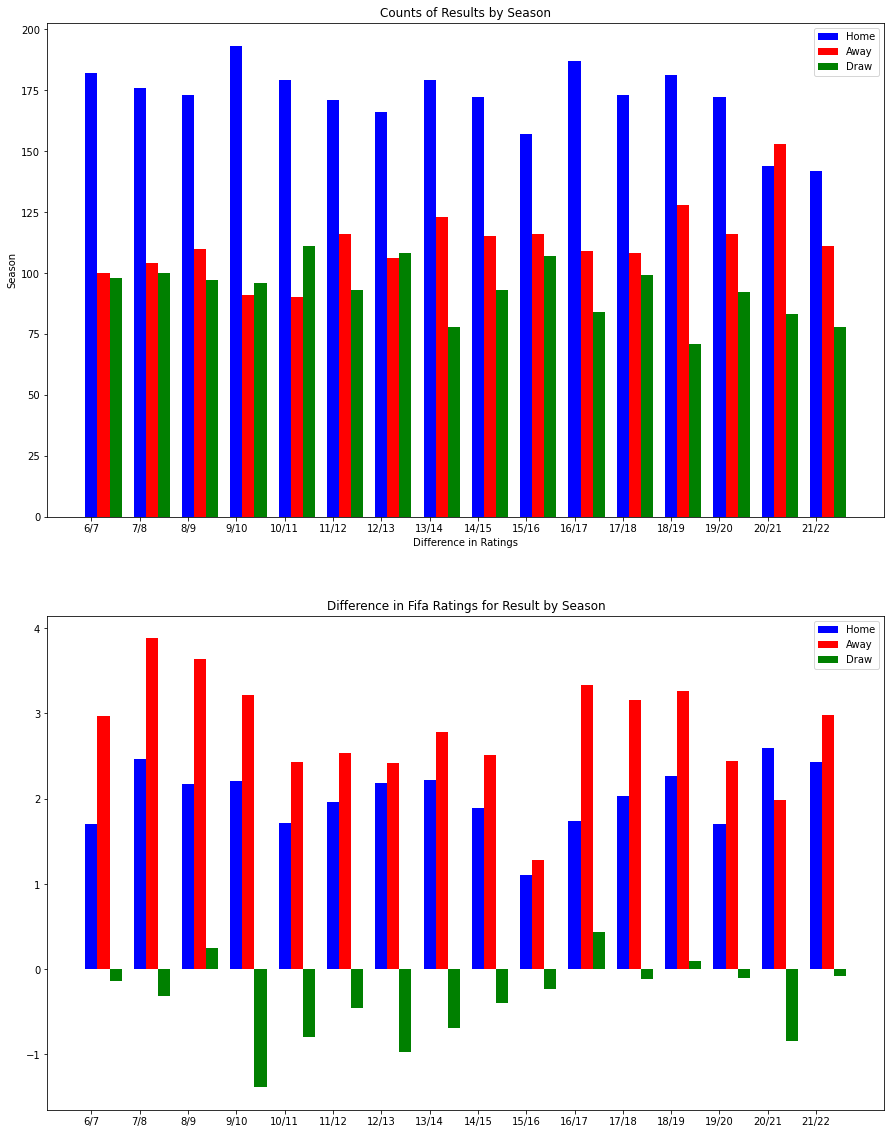

In [10]:
home_count = [by_season[x]['H'][0] for x in by_season]
home_diff = [by_season[x]['H'][1] for x in by_season]

away_count = [by_season[x]['A'][0] for x in by_season]
away_diff = [by_season[x]['A'][1] for x in by_season]

draw_count = [by_season[x]['D'][0] for x in by_season]
draw_diff = [by_season[x]['D'][1] for x in by_season]


X = np.arange(16)
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (15,20))

ax1.set_title('Counts of Results by Season')
ax1.bar(seasons,home_count,color='b',width = 0.25)
ax1.bar(X+.25,away_count,color='r',width = 0.25)
ax1.bar(X+.5,draw_count,color='g',width = 0.25)
ax1.legend(['Home','Away','Draw'])
ax1.set_xlabel('Season')
ax1.set_ylabel('Counts of Result')

ax2.set_title('Difference in Fifa Ratings for Result by Season')
ax2.bar(seasons,home_diff,color='b',width = 0.25)
ax2.bar(X+.25,away_diff,color='r',width = 0.25)
ax2.bar(X+.5,draw_diff,color='g',width = 0.25)
ax2.legend(['Home','Away','Draw'])
ax1.set_xlabel('Difference in Ratings')
ax1.set_ylabel('Season')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.2)
plt.show()

Both of these graphs give us some interesting information. 

Counts of Results by Season:
This graph is using no FIFA ratings and it reinforces the assumption that it is easier to be a winner at home. You can tell this as the vast majority of the games are won by the home team.

Difference in FIFA Ratings for W/L by Season:
From this graph we can begin to see how much easier it is to win at home as the average difference is typically lowest for home team wins. This would lead us to think that upsets and close games are often influenced by the home team's advantage. We also can draw from the draws (pun) that draws occur more often when the teams are close. Interestingly, the draws tend to be negative, implying that there are much more away draws.

From the second graph, I want to look at a few subtle outliers. 15/16 and 20/21.


#### 15/16
This was an extrmely historical season as it had Leicester City beat 5000/1 odds to win the premier league. 13th rated by FIFA, but finished 1st. Whereas previous champions and 1st rated Chelsea finished 10th. This could potentially be why the differences are so much smaller than any other season.

#### 20/21
This season is particularly important for this project as it was a season where fans could not watch the matches due to the Coronavirus. This can be seen in the plot as it the only season besides 11/12 and 12/13 where away difference is not higher.




Now that we have somewhat of an explanation for the outliers, we can begin to analyze this trend further for looking at the advantage home teams have. We will do this by standardizing each teams rating based. While we are at it, we will also do this for DEF and ATT. 

For team $i$ in year $j$, $$\text{standardized_OVR}_{i,j} = \frac{\text{OVR}_{i,j} - \text{mean_OVR}_j}{\text{OVR_std}_j}$$

$$\text{standardized_ATT}_{i,j} = \frac{\text{ATT}_{i,j} - \text{mean_standardized_ATT}_j}{\text{standardized_ATT_std}_j}$$

$$\text{standardized_DEF}_{i,j} = \frac{\text{DEF}_{i,j} - \text{mean_DEF}_j}{\text{DEF_std}_j}$$

The reason we want to do this is to ensure that FIFA's ratings are uniform over the years even though, just looking at the ratings, they generally seem to be equally spaced out and range from ~70-85. If we do not do this, across different FIFA's, an 80 rated team should always be equally good, but this may not always be true based on who is actually rating them. For example, the FIFA 12 rating method is most likely completely different than FIFA 22, with this, we are able to compare seasons to one another a little bit easier and more accurately.

In [11]:
df['HomeSOVR'] = 0
df['HomeSATT'] = 0
df['HomeSDEF'] = 0

df['AwaySOVR'] = 0
df['AwaySATT'] = 0
df['AwaySDEF'] = 0

df
season_stats = dict()
for x in lst:
    OVRs = np.array(list(int(x[0]) for x in lst[x].values()))
    ATTs = np.array(list(int(x[1]) for x in lst[x].values()))
    DEFs = np.array(list(int(x[2]) for x in lst[x].values()))
    
    season_stats[x] = [[OVRs.mean(),OVRs.std()],[ATTs.mean(),ATTs.std()],[DEFs.mean(),DEFs.std()]]
    
for i,row in df.iterrows():
    df.loc[i,'HomeSOVR'] = (row['HomeOVR'] - season_stats[row['Season']][0][0])/(season_stats[row['Season']][0][1])
    df.loc[i,'AwaySOVR'] = (row['AwayOVR'] - season_stats[row['Season']][0][0])/(season_stats[row['Season']][0][1])
    
    df.loc[i,'HomeSATT'] = (row['HomeATT'] - season_stats[row['Season']][1][0])/(season_stats[row['Season']][1][1])
    df.loc[i,'AwaySATT'] = (row['AwayATT'] - season_stats[row['Season']][1][0])/(season_stats[row['Season']][1][1])
    
    df.loc[i,'HomeSDEF'] = (row['HomeDEF'] - season_stats[row['Season']][2][0])/(season_stats[row['Season']][2][1])
    df.loc[i,'AwaySDEF'] = (row['AwayDEF'] - season_stats[row['Season']][2][0])/(season_stats[row['Season']][2][1])

Now that we have these standardized columns, we do not really need the old un-standardized ones.

In [12]:
df = df.drop(['HomeOVR','HomeATT','HomeDEF','AwayOVR','AwayATT','AwayDEF'],axis=1)

Then we can also use a difference based on standardized values too.

In [13]:
for i,row in df.iterrows():
    if row['FTR'] == 'H':
        df.at[i,'DiffSFT'] = row['HomeSOVR'] - row['AwaySOVR']
    elif row['FTR'] == 'A':
        df.at[i,'DiffSFT'] = row['AwaySOVR'] - row['HomeSOVR']
    else:
        df.at[i,'DiffSFT'] = (row['HomeSOVR'] - row['AwaySOVR'])
df = df.drop(['DiffFT'],axis=1)

Then for fun, we can replot our previous plot to ensure everything sitll holds.

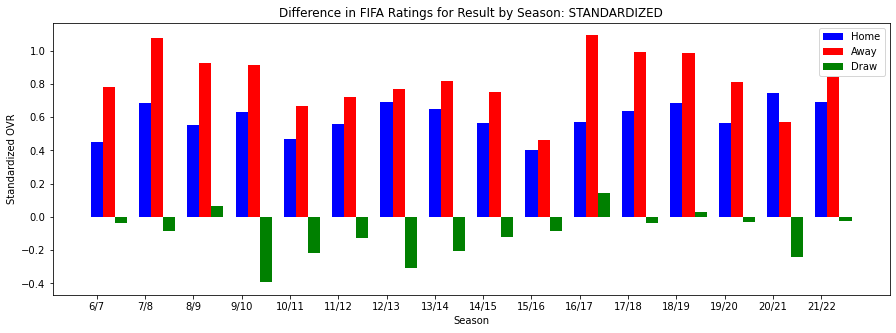

In [14]:
seasons = np.flip(df['Season'].unique())
by_season_std = dict()
for i,e in enumerate(seasons):
    season = df.loc[df['Season'] == e]
    by_season_std[e] = {'H':season.loc[season.FTR == 'H','DiffSFT'].mean(),
                   'A':season.loc[season.FTR == 'A','DiffSFT'].mean(),
                   'D':season.loc[season.FTR == 'D','DiffSFT'].mean()}
by_season

home_diff = [by_season_std[x]['H'] for x in by_season_std]

away_diff = [by_season_std[x]['A'] for x in by_season_std]

draw_diff = [by_season_std[x]['D'] for x in by_season_std]


X = np.arange(16)
fig,(ax1) = plt.subplots(1,1,figsize = (15,5))

ax1.set_title('Difference in FIFA Ratings for Result by Season: STANDARDIZED')
ax1.bar(seasons,home_diff,color='b',width = 0.25)
ax1.bar(X+.25,away_diff,color='r',width = 0.25)
ax1.bar(X+.5,draw_diff,color='g',width = 0.25)
ax1.legend(['Home','Away','Draw'])
ax1.set_xlabel('Season')
ax1.set_ylabel('Standardized OVR')

plt.show()

Although this did not change our plot very much, it does put each seasons ratings on a more uniform scale in relation to one another. 

But overall, from the graphs shown using FIFA ratings, they seem to reinforce the idea that home teams tend to do better and win more.

Next, I want to look at the relationship between the FIFA attacking and defending stats with the actual goals scored/conceded. We can do this by graphing attacking with goals scored in a match (win, lose, or draw) and defending with goals conceded in a match (win, lose, or draw). We can do this by looking at two seperate violin plots for goals scored/conced for each value of goals. To help us with this, it may be easier first to create a dataframe of each which holds just two columns, goals scored and standardized attacking.

In [15]:
df
df['AHDiff'] = [row['AwaySATT'] - row['HomeSDEF'] for i,row in df.iterrows()]
df['HADiff'] = [row['HomeSATT'] - row['AwaySDEF'] for i,row in df.iterrows()]
df
df.sort_values('AHDiff')

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HomeSOVR,HomeSATT,HomeSDEF,AwaySOVR,AwaySATT,AwaySDEF,DiffSFT,AHDiff,HADiff
5761,11/11/06,Chelsea,Watford,4,0,H,6/7,1.960017,1.576838,1.778479,-2.249416,-2.238092,-1.563629,4.209433,-4.016571,3.140466
5070,26/12/08,Chelsea,West Brom,2,0,H,8/9,1.914287,1.619682,1.719573,-1.403811,-2.275756,-1.332923,3.318098,-3.995329,2.952606
4965,18/10/08,Man United,West Brom,4,0,H,8/9,1.914287,1.414659,1.719573,-1.403811,-2.275756,-1.332923,3.318098,-3.995329,2.747583
2372,05/12/2015,Chelsea,Bournemouth,0,1,A,15/16,2.045773,1.131225,2.009519,-1.575064,-1.953935,-1.485297,-3.620836,-3.963454,2.616522
3820,15/10/11,Chelsea,Everton,3,1,H,11/12,1.619352,1.518530,1.888176,-0.089964,-1.943718,0.475761,1.709316,-3.831894,1.042769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,08/11/2020,West Brom,Tottenham,0,1,A,20/21,-1.503841,-1.120840,-1.770513,1.074172,2.241679,1.126690,2.578014,4.012192,-2.247529
5560,15/03/08,Derby,Man United,0,1,A,7/8,-1.907125,-1.191499,-1.940285,1.962404,2.118220,1.697749,3.869530,4.058505,-2.889248
2658,21/09/14,Leicester,Man United,5,3,H,14/15,-1.251642,-1.456986,-1.847662,1.430448,2.251705,0.238408,-2.682090,4.099367,-1.695394
3399,02/09/12,Southampton,Man United,2,3,A,12/13,-1.118844,-1.456615,-2.112173,1.736714,2.122138,1.789480,2.855558,4.234311,-3.246095


In [16]:
scored = []
att = []
conceded = []
deff = []

a=[]
b=[]

for i,row in df.iterrows():
    a.append(row['HADiff'])
    a.append(row['AHDiff'])
    b.append(row['FTHG'])
    b.append(row['FTAG'])
    
    scored.append(row['FTHG'])
    scored.append(row['FTAG'])
    att.append(row['HomeSATT'])
    att.append(row['AwaySATT'])
    
    conceded.append(row['FTAG'])
    conceded.append(row['FTHG'])
    deff.append(row['HomeSDEF'])
    deff.append(row['AwaySDEF'])

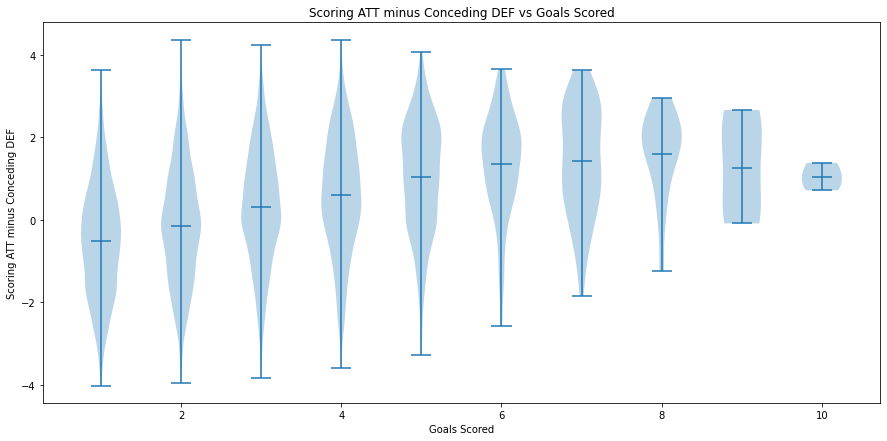

In [17]:
fig,ax = plt.subplots(figsize = (15,7))

df1 = pd.DataFrame({'Differences':a,'Goals':b})
scores = df1['Goals'].unique()
scores.sort()
scored = [None]*len(scores)
for i,row in df1.iterrows():
    index = int(row['Goals'])
    if not scored[index]:
        scored[index] = []
    scored[index].append(row['Differences'])
ax.violinplot(scored,showmeans = True)
ax.set_xlabel('Goals Scored')
ax.set_ylabel('Scoring ATT minus Conceding DEF')
ax.set_title('Scoring ATT minus Conceding DEF vs Goals Scored')
plt.show()

This plot is effectively showing how the difference between the goal scoring team's ATT and the goal conceding team's DEF affects the amount of goals scored. This is effectively showing that the higher the difference, the more goals scored. Which fits our intution. A part about this graph that is misleading is that the amount of data points making up each violin varies greatly (for example in this dataset only 3 teams have scored 9 goals). Plotting this with equi-depth buckets based on Goal Scorer ATT minus Conceding DEF would be much better.

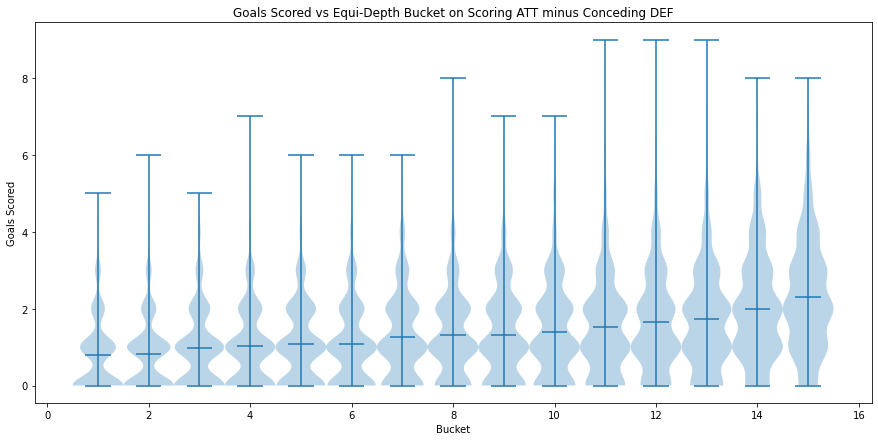

Buckets:
[(-1.297, -0.931], (0.348, 0.64], (1.708, 2.224], (-1.701, -1.297], (-0.338, -0.109], ..., (-0.109, 0.12], (0.921, 1.275], (-1.297, -0.931], (-2.243, -1.701], (2.224, 4.365]]
Length: 12062
Categories (15, interval[float64]): [(-4.018000000000001, -2.243] < (-2.243, -1.701] < (-1.701, -1.297] < (-1.297, -0.931] ... (0.921, 1.275] < (1.275, 1.708] < (1.708, 2.224] < (2.224, 4.365]]


In [18]:
fig, ax = plt.subplots(figsize=(15,7))
p = 15
df1['bucket'] = pd.qcut(df1['Differences'],q=p,labels = [x for x in range(0,p)])

buckets = [None]*p
for i,row in df1.iterrows():
    index = int(row['bucket'])
    if not buckets[index]:
        buckets[index] = []
    buckets[index].append(row['Goals'])
ax.violinplot(buckets,widths = 1, showmeans = True)
ax.set_xlabel("Bucket")
ax.set_ylabel("Goals Scored")
ax.set_title("Goals Scored vs Equi-Depth Bucket on Scoring ATT minus Conceding DEF")

plt.show()
print("Buckets:")
print(pd.qcut(df1['Differences'].values,q=p))

This gives us an extremely interesting result. The buckets, by definition, are increasing, and their widths are varying, but their depths are equal. In reality, we can pick any size buckets to communicate the result we found earlier. As the difference between attack and defense increase, the more goals are scored by the attack. This graphic could somewhat also be misleading as it may be assumed that the x-axis is constantly increasing, when in reality, it is increasing at a varying decreasing rate as each bucket gets smaller and smaller because there are more matches played between two teams with ATT and DEF close to the mean.

Now that we have shown the correlation, we can now start experiementing with some machine learning classification algorithms to see how good of predictors FIFA really are ith their ratings.

We will use many different models to try to find the mst accurate classifier. We will use K-Nearest Neighbors, Decision Tree, Logistic Regression, Naive Bayes, and Vector Machines. But first, to see if our guess are any good in the first place, we will set up a funciton to randomly guess. But first we must recognize something.

In [19]:
df['FTR'].value_counts()

H    2747
A    1796
D    1488
Name: FTR, dtype: int64

Our data has many more home win results as we showed before. This would cause a decievingly good model to just do well if it guess mored home games. To ensure our model is better than that, we will set up our random model to randomly pick H $\frac{2747}{1796+2747+1488}=\frac{2747}{6031}\approx0.45=\frac{45}{100}$, randomly pick A $\frac{1796}{6031}\approx0.30=\frac{30}{100}$, and finally pick D $\frac{1488}{6031}\approx0.25=\frac{25}{100}.$ 

So we will pick a random number x from 0 to 99, 

$x < 45 \to H,$ 

$45 \leq x < 75 \to A,$ 

$75 \leq x \to D.$

In [20]:
import random
def random_guess(l): 
    guess = [None]*l
    for i in range(l):
        rand = random.randint(0,99)
        result_guess = 'D'
        if rand < 45:
            result_guess = 'H'
        elif 45 <= rand < 75:
            result_guess = 'A'
        
        guess[i]= result_guess
    return guess

I also want to add a random guesser that completely ignores draws as they are rare and hard to guess. We will split it up so Home and Away guesses each get half of what Draws would have gotten. So we will add on $\frac{25}{100}\cdot\frac{1}{2}~\frac{12}{100}$ to each. Then the guess is predicted a similar way to above.

In [21]:
def random_guess_no_draw(l): 
    guess = [None]*l
    for i in range(l):
        rand = random.randint(0,99)
        result_guess = 'H'
        if rand < 57:
            result_guess = 'A'
        guess[i]= result_guess
    return guess

Also, because of this class balancing issue, we will use another Logistic Regression model which has the property class_weight, which we can set to balanced.

Now we can begin the machine learning. First lets create a dummy split.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

import sklearn.metrics as met
import sklearn.model_selection as ms

df['target'] = 0

for i,row in df.iterrows():
    if row['FTR'] == 'H':
        df.at[i,'target'] = 0
    elif row['FTR'] == 'A':
        df.at[i,'target'] = 1
    else:
        df.at[i,'target'] = 2

dep = pd.Categorical.from_codes(df['target'],['H','A','D'])
split = pd.get_dummies(dep)

Next lets create the dataset we will split on that has no information about the actual result but just the FIFA ratings and the specific differences we defined above. We are also just going to use Home/Away Overall, and then Home Attack minus Away Defense,  and Away attack minus home defense.

In [23]:
dft = df.loc[:, df.columns.intersection(['HomeSOVR','AwaySOVR','AHDiff','HADiff'])]
dft

,HomeSOVR,AwaySOVR,AHDiff,HADiff
0,-1.270254,0.423418,0.600677,-1.149282
1,1.270254,-0.705697,-1.426181,1.779968
2,-0.705697,-0.705697,-0.565962,-0.267976
3,1.552533,-0.705697,-2.005283,2.367505
4,-0.141139,-0.705697,-0.855513,0.315343
...,...,...,...,...
6026,-0.144699,-0.407789,-0.087772,0.197769
6027,-0.407789,1.433838,1.199477,-2.267483
6028,-1.197058,-0.670878,0.119736,0.405278
6029,0.644569,0.118390,-1.265776,0.945149


Then we create out training and testing set split.

In [24]:
ind_train_n, ind_test_n, dep_train_n, dep_test_n = ms.train_test_split(dft, dep,random_state=69420)
ind_train_n

,HomeSOVR,AwaySOVR,AHDiff,HADiff
1918,-0.098321,-0.098321,-0.066759,-0.123225
2005,-1.081531,0.884889,1.762037,-2.350931
582,-0.644503,0.214834,0.678354,-0.609292
4610,0.625768,0.625768,0.049093,0.344611
1554,1.838251,-0.361366,-2.675114,1.309524
...,...,...,...,...
2782,-1.847662,0.834428,1.615898,-1.695394
5194,-1.403811,-0.127619,1.310898,-1.957285
589,1.933510,0.214834,-2.218848,1.184052
2942,-0.357612,-0.357612,0.556272,-0.006644


Then we can finally begin using our models. We will plot them for certain hyper parameters if available. For kNN we have n_neighbors, and decision trees with have max depth. We will define this as a method run_models. It will plot all of our models solely based on accuracy_score, and it will tell us the best percentage for each method and the best hyper parameter value if applicable.

0.5324933687002652 is kNN's max 

best_n_neighbors = 69 

0.5324933687002652 is DecisionTree's max 

best_max_depth = 3 

0.5305039787798409 is LogisticRegression's max 

0.5305039787798409 is LogisticRegressionBalanced's max 

0.5145888594164456 is NaiveBayes's max 

0.536472148541114 is VectorMachine's max 

0.36780942671703193 is Random's max 

0.4073475661085435 is Random No Draws's max 

Random's mean is 0.33404126733420114 

Random No Draw's mean is 0.3800233571675979 



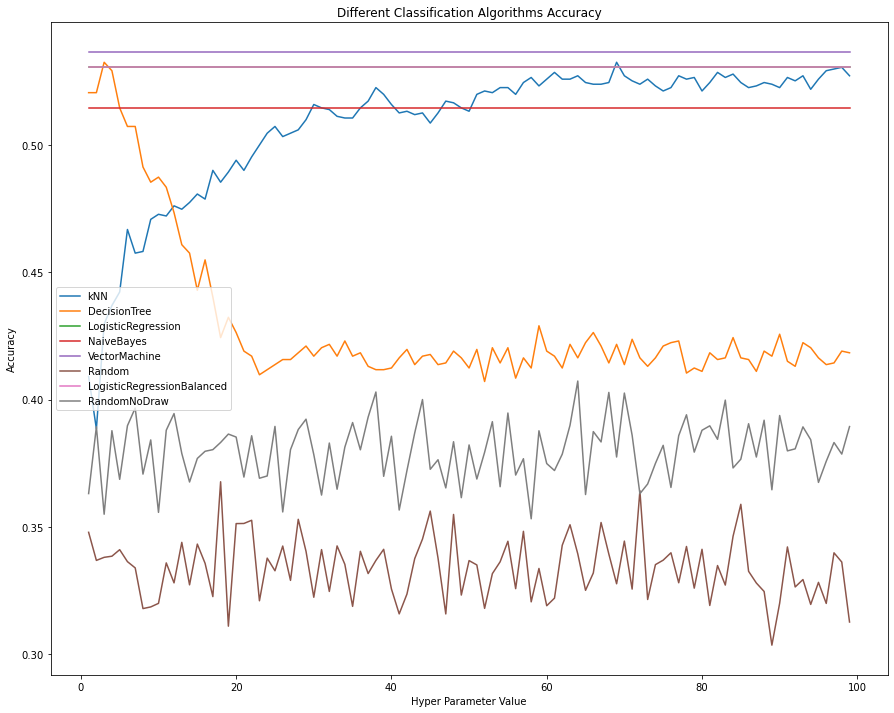

In [25]:
import warnings

actual_n = np.array(dep_test_n)
def run_models(actual, ind_train, ind_test, dep_train, dep_test):    
    def test_classification_method(c):
        c.fit(ind_train, dep_train)
        predicted = c.predict(ind_test)
        predictions = np.array(predicted)
        return met.accuracy_score(predictions,actual)

    lr = LogisticRegression()
    lr_acc = test_classification_method(lr)   

    lr_bal = LogisticRegression(class_weight = 'balanced')
    lr_bal_acc = test_classification_method(lr)

    nb = GaussianNB()
    nb_acc = test_classification_method(nb)  
    
    vm = svm.SVC()
    vm_acc = test_classification_method(vm)

    def test_all_methods(x):
        knn = KNeighborsClassifier(n_neighbors = x)
        knn_acc = test_classification_method(knn)

        dt = DecisionTreeClassifier(max_depth = x)
        dt_acc = test_classification_method(dt)

        rand_acc = met.balanced_accuracy_score(random_guess(len(ind_test)),actual)
        
        # ignoring warnings because it gets annoyed when there are no 'D' guesses.
        warnings.filterwarnings("ignore")
        rand_nd_acc = met.balanced_accuracy_score(random_guess_no_draw(len(ind_test)),actual)

        return (knn_acc,dt_acc,lr_acc,nb_acc,vm_acc,rand_acc,lr_bal_acc,rand_nd_acc)

    fig,ax = plt.subplots(figsize=(15,12))

    hp = 100
    x = range(1,hp)
    y = list(map(test_all_methods, x))

    ax.plot(x,y)
    ax.legend(['kNN','DecisionTree','LogisticRegression','NaiveBayes','VectorMachine',
               'Random','LogisticRegressionBalanced','RandomNoDraw'])
    ax.set_title('Different Classification Algorithms Accuracy')
    ax.set_xlabel("Hyper Parameter Value")
    ax.set_ylabel("Accuracy")
    def print_max(name, index):
        l = [x[index] for x in y]
        m = max(l)
        print(str(m),'is',name+'\'s max','\n')

    print_max('kNN',0)
    l = [x[0] for x in y]
    m = max(l)
    best_n_neighbors = l.index(m) + 1
    print('best_n_neighbors =',best_n_neighbors,'\n')
    print_max('DecisionTree',1)
    l = [x[1] for x in y]
    m = max(l)
    best_max_depth = l.index(m) + 1
    print('best_max_depth =',best_max_depth,'\n')
    print_max('LogisticRegression',2)
    print_max('LogisticRegressionBalanced',6)
    print_max('NaiveBayes',3)
    print_max('VectorMachine',4)
    print_max('Random',5)
    print_max('Random No Draws',7)
    print('Random\'s mean is',np.mean([x[5] for x in y]),'\n')
    print('Random No Draw\'s mean is',np.mean([x[7] for x in y]),'\n')
    
run_models(actual_n, ind_train_n, ind_test_n, dep_train_n, dep_test_n)

After this, we can see that all of our models did better than our random guesser's. But not by too much. We can look at our confusion matrices below.

In [26]:
best_n_neighbors = 67
best_max_depth = 1

def run_conf(actual, ind_train, ind_test, dep_train, dep_test):
    def print_conf(c,name):
        c.fit(ind_train, dep_train)
        predicted = c.predict(ind_test)
        predictions = np.array(predicted)
        matrix = met.confusion_matrix(actual, predictions)
        print(name,'\n',matrix.diagonal()/matrix.sum(axis=1),'\n',matrix)

    print_conf(KNeighborsClassifier(n_neighbors = best_n_neighbors),"kNN")
    print_conf(DecisionTreeClassifier(max_depth = best_max_depth),"Decision Trees")
    print_conf(LogisticRegression(),"Logistic Regression")
    print_conf(LogisticRegression(class_weight = 'balanced'),'Logistic Regression Balanced')
    print_conf(GaussianNB(),"Naive Bayes's")
    print_conf(svm.SVC(),"Vector Machine")
run_conf(actual_n, ind_train_n, ind_test_n, dep_train_n, dep_test_n)

kNN 
 [0.49777778 0.0498615  0.78622669] 
 [[224  22 204]
 [107  18 236]
 [124  25 548]]
Decision Trees 
 [0.64       0.         0.71305595] 
 [[288   0 162]
 [163   0 198]
 [200   0 497]]
Logistic Regression 
 [0.53777778 0.         0.80057389] 
 [[242   0 208]
 [118   0 243]
 [139   0 558]]
Logistic Regression Balanced 
 [0.56888889 0.26869806 0.58536585] 
 [[256  99  95]
 [131  97 133]
 [150 139 408]]
Naive Bayes's 
 [0.59111111 0.08033241 0.69010043] 
 [[266  39 145]
 [142  29 190]
 [172  44 481]]
Vector Machine 
 [0.46888889 0.         0.8579627 ] 
 [[211   0 239]
 [ 94   0 267]
 [ 99   0 598]]


So although most of them a decent accuracy better than randomly guessing, they also have very poor matching ability as many of them think it is okay to just ignore the draw result as it still gives them high accuracy. To combat this, we will try oversampling our data by randomly deleting Home wins from our data initially, and then re running our models. Without this, only the balanced logistic regression model has any strength/use. One thing to note, is that as we remove this data, we are losing information, so it may weaken our models, but if the undersampling is random, it should not hurt them too much.

Also, I chose to do this instead of over sampling as over sample duplicates rows from less common categories. This is introducing technically misleading information and I felt this would overfit our data much more than undersampling will underfit our data.

In [27]:
df['FTR'].value_counts()

H    2747
A    1796
D    1488
Name: FTR, dtype: int64

We will try to get H's count to around halfway between A and D's counts. So $\frac{1796+1488}{2}=1642$. That is $\frac{1642}{2747}\approx0.6$, so for every H we see, we remove 0.4. So a random number 1 to 5, we will remove 1s and 2s.

We will follow the exact same approach as before.

In [28]:
df_undersample = df.copy()
for i,row in df.iterrows():
    if row['FTR'] == 'H' and random.randint(1,5) <= 2:
        df_undersample.drop([i],axis=0,inplace=True)
df_undersample['FTR'].value_counts()

A    1796
H    1649
D    1488
Name: FTR, dtype: int64

0.4991896272285251 is kNN's max 

best_n_neighbors = 68 

0.4813614262560778 is DecisionTree's max 

best_max_depth = 3 

0.49027552674230146 is LogisticRegression's max 

0.49027552674230146 is LogisticRegressionBalanced's max 

0.4821717990275527 is NaiveBayes's max 

0.48703403565640196 is VectorMachine's max 

0.36399949074895827 is Random's max 

0.3851570394922996 is Random No Draws's max 

Random's mean is 0.33055222514604604 

Random No Draw's mean is 0.35309005895415657 

kNN 
 [0.59775281 0.26997245 0.55399061] 
 [[266  82  97]
 [138  98 127]
 [100  90 236]]
Decision Trees 
 [0.49662921 0.47658402 0.42488263] 
 [[221 169  55]
 [111 173  79]
 [ 60 185 181]]
Logistic Regression 
 [0.66741573 0.10192837 0.63615023] 
 [[297  43 105]
 [173  37 153]
 [106  49 271]]
Logistic Regression Balanced 
 [0.57303371 0.25895317 0.57746479] 
 [[255  91  99]
 [132  94 137]
 [ 80 100 246]]
Naive Bayes's 
 [0.6        0.20385675 0.59624413] 
 [[267  82  96]
 [146  74 143]
 [ 87  85 254]]
Vector 

(LogisticRegression(class_weight='balanced'),
 LogisticRegression(class_weight='balanced'))

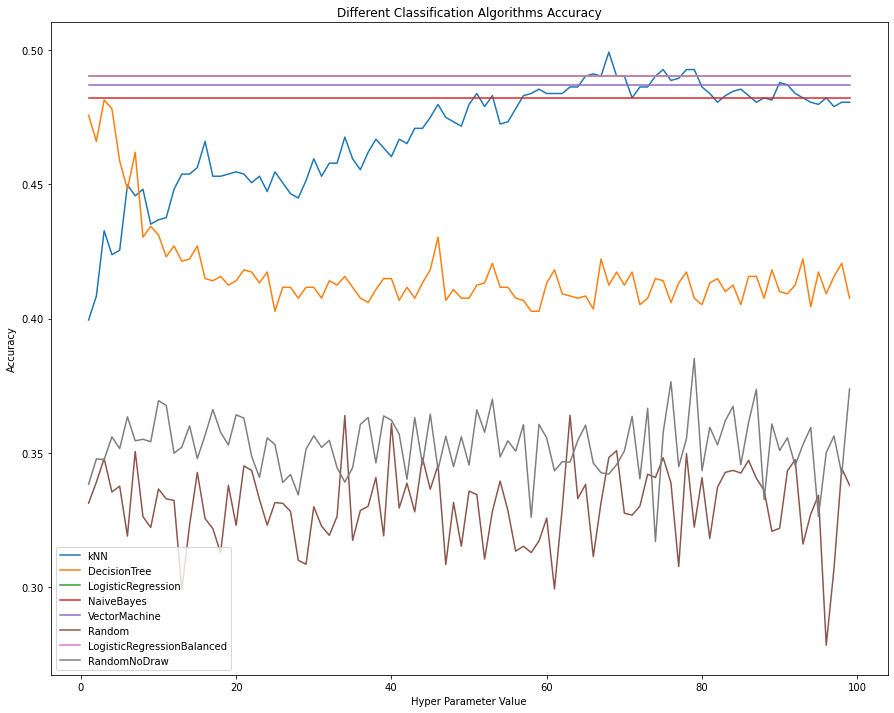

In [29]:
dft = df_undersample.loc[:, df_undersample.columns.intersection(['HomeSOVR','AwaySOVR','AHDiff','HADiff'])]
dep = pd.Categorical.from_codes(df_undersample['target'],['H','A','D'])
split = pd.get_dummies(dep)
ind_train_us, ind_test_us, dep_train_us, dep_test_us = ms.train_test_split(dft, dep,random_state=69420)
actual_us = np.array(dep_test_us)

run_models(actual_us,ind_train_us, ind_test_us, dep_train_us, dep_test_us)
best_n_neighbors = 80
best_max_depth = 2
run_conf(actual_us,ind_train_us, ind_test_us, dep_train_us, dep_test_us)

lr_bal_undersample = LogisticRegression(class_weight = 'balanced').fit(ind_train_us, dep_train_us)
lr_bal = LogisticRegression(class_weight = 'balanced').fit(ind_train_n, dep_train_n)

lr_bal, lr_bal_undersample

So using undersampling we see our accuracies take a few percentage drops, however our models are beginning to predict a lot better. Specifically kNN and Decision Trees are seeming to do very well on all results where as balanced logistic regression is doing very similar to the others. However, specifically for kNN and Decision Trees, there could be overfitting involved. To test some of these final models, we will do our final predictions by seeing which model can get the most accurate entire season correct. We will do this by taking all of the matches for a given season, calculating the points for each match predicted by the model, and sort by the points, in turn, predicting a premier league season.

In [41]:
seasons = df['Season'].unique()

def point_calc(res, team):
    if res == 'D':
        return 1
    if res == team:
        return 3
    return 0   



real_results = dict()
seasons_dict = dict()

for i in seasons:
    season = df[df['Season'] == i].copy()
    
    teams = season['HomeTeam'].unique()
    points = [0]*20
    gd = [0]*20
    league = pd.DataFrame({'Team':teams, 'Points':points, 'GD':gd})
    for j,row in season.iterrows():
        league.loc[league['Team'] == row['HomeTeam'], 'Points'] += point_calc(row['FTR'],'H')
        league.loc[league['Team'] == row['AwayTeam'], 'Points'] += point_calc(row['FTR'],'A')
        league.loc[league['Team'] == row['HomeTeam'], 'GD'] += row['FTHG'] - row['FTAG']
        league.loc[league['Team'] == row['AwayTeam'], 'GD'] += row['FTAG'] - row['FTHG']
        
    league.sort_values(['Points','GD'],ascending = False,inplace=True)
    league.reset_index(inplace=True)
    
    real_results[i] = league
    seasons_dict[i] = season
    
def predict_seasons(c):
    for i in seasons:
        season = df[df['Season'] == i].copy()

        fteams = season['HomeTeam'].unique()
        fpoints = [0]*20
        fleague = pd.DataFrame({'Team':teams, 'Points':points})

        dft_season = season.loc[:, season.columns.intersection(['HomeSOVR','AwaySOVR','AHDiff','HADiff'])]
        predicted = c.predict(dft_season)
        predictions = np.array(predicted)
        season['Prediction'] = predictions

        for j,row in season.iterrows():      
            fleague.loc[fleague['Team'] == row['HomeTeam'], 'Points'] += point_calc(row['Prediction'],'H')
            fleague.loc[fleague['Team'] == row['AwayTeam'], 'Points'] += point_calc(row['Prediction'],'A')

        fleague.sort_values(['Points'],ascending = False,inplace=True)
        fleague.reset_index(inplace=True)
        print(i,fleague,sep='\n')
        
        real_season = real_results[i]
        print(real_season)

In [40]:
lr_bal = LogisticRegression(class_weight='balanced')
lr_bal.fit(ind_train_us,dep_train_us)
predict_seasons(lr_bal)

21/22
    index              Team  Points
0      18         Liverpool      96
1      16          Man City      96
2       9        Man United      87
3       8           Chelsea      84
4      10         Tottenham      78
5       0           Arsenal      63
6       7          West Ham      59
7       2           Everton      39
8      12       Aston Villa      38
9       3         Newcastle      30
10     11           Watford      12
11      6  Sheffield United       0
12      5           Reading       0
13      4        Portsmouth       0
14      1            Bolton       0
15     13         Blackburn       0
16     14          Charlton       0
17     15            Fulham       0
18     17     Middlesbrough       0
19     19             Wigan       0
20/21
    index              Team  Points
0      18         Liverpool     111
1      16          Man City     111
2      10         Tottenham      96
3       8           Chelsea      95
4       9        Man United      95
5       0       

10/11
    index              Team  Points
0       8           Chelsea     111
1       9        Man United     108
2      16          Man City     102
3       0           Arsenal      96
4      18         Liverpool      90
5      10         Tottenham      87
6      12       Aston Villa      72
7       2           Everton      72
8      15            Fulham      66
9       1            Bolton      30
10      7          West Ham      26
11     13         Blackburn      26
12     19             Wigan      22
13      3         Newcastle      21
14      6  Sheffield United       0
15      5           Reading       0
16      4        Portsmouth       0
17     11           Watford       0
18     14          Charlton       0
19     17     Middlesbrough       0
9/10
    index              Team  Points
0       8           Chelsea     108
1       9        Man United     108
2      18         Liverpool     105
3       0           Arsenal      96
4      16          Man City      93
5      12       A

In [39]:
lr_bal = LogisticRegression(class_weight='balanced')
lr_bal.fit(ind_train_n,dep_train_n)
predicted = lr_bal.predict(dft)
predictions = np.array(predicted)
len(predictions)

6031

In [32]:
dft = df.loc[:, df.columns.intersection(['HomeSOVR','AwaySOVR','AHDiff','HADiff'])]
dft

,HomeSOVR,AwaySOVR,AHDiff,HADiff
0,-1.270254,0.423418,0.600677,-1.149282
1,1.270254,-0.705697,-1.426181,1.779968
2,-0.705697,-0.705697,-0.565962,-0.267976
3,1.552533,-0.705697,-2.005283,2.367505
4,-0.141139,-0.705697,-0.855513,0.315343
...,...,...,...,...
6026,-0.144699,-0.407789,-0.087772,0.197769
6027,-0.407789,1.433838,1.199477,-2.267483
6028,-1.197058,-0.670878,0.119736,0.405278
6029,0.644569,0.118390,-1.265776,0.945149
